In [1]:
# Install required packages
%pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip install -q ultralytics
%pip install -q pandas numpy matplotlib seaborn Pillow opencv-python scikit-learn tqdm albumentations
%pip install -q pycocotools torchmetrics

Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Chest X-ray Detection Challenge

## Approach Overview
This notebook implements an object detection pipeline for identifying pathological findings on chest X-rays using:
- **Model**: Faster R-CNN with ResNet-50 FPN backbone
- **Transfer Learning**: Pre-trained on COCO dataset
- **Training**: Fine-tuned on NIH ChestXray dataset with bounding box annotations
- **Evaluation**: Mean Average Precision (mAP) at IoU=0.5

## Dataset
- **Images**: Chest X-ray images (PNG format)
- **Annotations**: Bounding boxes for multiple pathology classes
- **Task**: Multi-class object detection

# 1. Import Libraries

In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm

# 2. Data Exploration

In [3]:
BASE_PATH = "/kaggle/input/m-2-big-data-dlia-project-2025-clean-dataset"

TRAIN_CSV = f"{BASE_PATH}/train.csv"
ID_MAP   = f"{BASE_PATH}/ID_to_Image_Mapping.csv"
TRAIN_IMG_DIR = f"{BASE_PATH}/train"
TEST_IMG_DIR  = f"{BASE_PATH}/test"

In [4]:
train_df = pd.read_csv(TRAIN_CSV)
id_map = pd.read_csv(ID_MAP)

In [5]:
print(f"Training samples: {len(train_df)}")
print(f"Unique images: {train_df['image_id'].nunique()}")
print(f"Number of classes: {train_df['label'].nunique()}")
print(f"\nClass distribution:")
print(train_df['label'].value_counts())

Training samples: 814
Unique images: 710
Number of classes: 8

Class distribution:
label
Atelectasis     145
Effusion        130
Cardiomegaly    112
Infiltrate      106
Pneumonia        98
Pneumothorax     86
Mass             77
Nodule           60
Name: count, dtype: int64


In [6]:
import pandas as pd
labels = sorted(train_df['label'].unique())
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}

num_classes = len(label2id) + 1
label2id, id2label, num_classes

({'Atelectasis': 0,
  'Cardiomegaly': 1,
  'Effusion': 2,
  'Infiltrate': 3,
  'Mass': 4,
  'Nodule': 5,
  'Pneumonia': 6,
  'Pneumothorax': 7},
 {0: 'Atelectasis',
  1: 'Cardiomegaly',
  2: 'Effusion',
  3: 'Infiltrate',
  4: 'Mass',
  5: 'Nodule',
  6: 'Pneumonia',
  7: 'Pneumothorax'},
 9)

# 3. Model Setup

In [7]:
class ChestXRayDataset(Dataset):
  def __init__(self, df, image_dir, transforms=None):
    self.df = df
    self.image_dir = image_dir
    self.transforms = transforms
    self.images = df['image_id'].unique()

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img_name = self.images[idx]
    records = self.df[self.df['image_id'] == img_name]
    img_path = os.path.join(self.image_dir, img_name)
    img = Image.open(img_path).convert('RGB')

    boxes = []
    labels = []
    for _, row in records.iterrows():
      x_min = row['x_min']
      y_min = row['y_min']
      x_max = row['x_max']
      y_max = row['y_max']
      boxes.append([x_min, y_min, x_max, y_max])
      labels.append(label2id[row['label']])

    target = {
        'boxes': torch.as_tensor(boxes, dtype=torch.float32),
        'labels': torch.as_tensor(labels, dtype=torch.int64),
    }

    image = torchvision.transforms.ToTensor()(img) # Corrected typo and variable
    return image, target

In [8]:
image_dir = TRAIN_IMG_DIR # This should be the directory containing image files, not the CSV file

transform = torchvision.transforms.Compose([
torchvision.transforms.Resize((1024, 1024)),
torchvision.transforms.ToTensor()
])

dataset = ChestXRayDataset(train_df, image_dir, transform)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    dataset,
    batch_size=4,             # detection models prefer small batches
    shuffle=True,
    num_workers=8,            # try 4–8
    pin_memory=True,
    persistent_workers=True,
    collate_fn=collate_fn     # required for detection
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
model = fasterrcnn_resnet50_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model = model.cuda() if torch.cuda.is_available() else model.cpu()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 194MB/s]


# 4. Training

In [10]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
num_epochs = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

scaler = torch.cuda.amp.GradScaler()  # AMP

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for images, targets in tqdm(train_loader, leave=False):
        images = [img.to(device, non_blocking=True) for img in images]
        targets = [
            {k: v.to(device, non_blocking=True) for k, v in t.items()}
            for t in targets
        ]

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast():
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f}")

/tmp/ipykernel_24/1964341912.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # AMP
  0%|          | 0/178 [00:00<?, ?it/s]/tmp/ipykernel_24/1964341912.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/2 | Loss: 48.9874


Epoch 2/2 | Loss: 42.8853


# 5. Evaluation

In [11]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

metric = MeanAveragePrecision(iou_thresholds=[0.5])

model.eval()
with torch.no_grad():
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(images)

        preds = [{
            "boxes": o["boxes"].cpu(),
            "scores": o["scores"].cpu(),
            "labels": o["labels"].cpu()
        } for o in outputs]

        targets = [{
            "boxes": t["boxes"].cpu(),
            "labels": t["labels"].cpu()
        } for t in targets]

        metric.update(preds, targets)

metric.compute()


{'map': tensor(0.1363),
 'map_50': tensor(0.1363),
 'map_75': tensor(-1.),
 'map_small': tensor(0.0117),
 'map_medium': tensor(0.0693),
 'map_large': tensor(0.1397),
 'mar_1': tensor(0.3569),
 'mar_10': tensor(0.5471),
 'mar_100': tensor(0.5493),
 'mar_small': tensor(0.5000),
 'mar_medium': tensor(0.1934),
 'mar_large': tensor(0.5359),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([0, 1, 2, 3, 4, 5, 6, 7], dtype=torch.int32)}

# 6. Visualization of Predictions

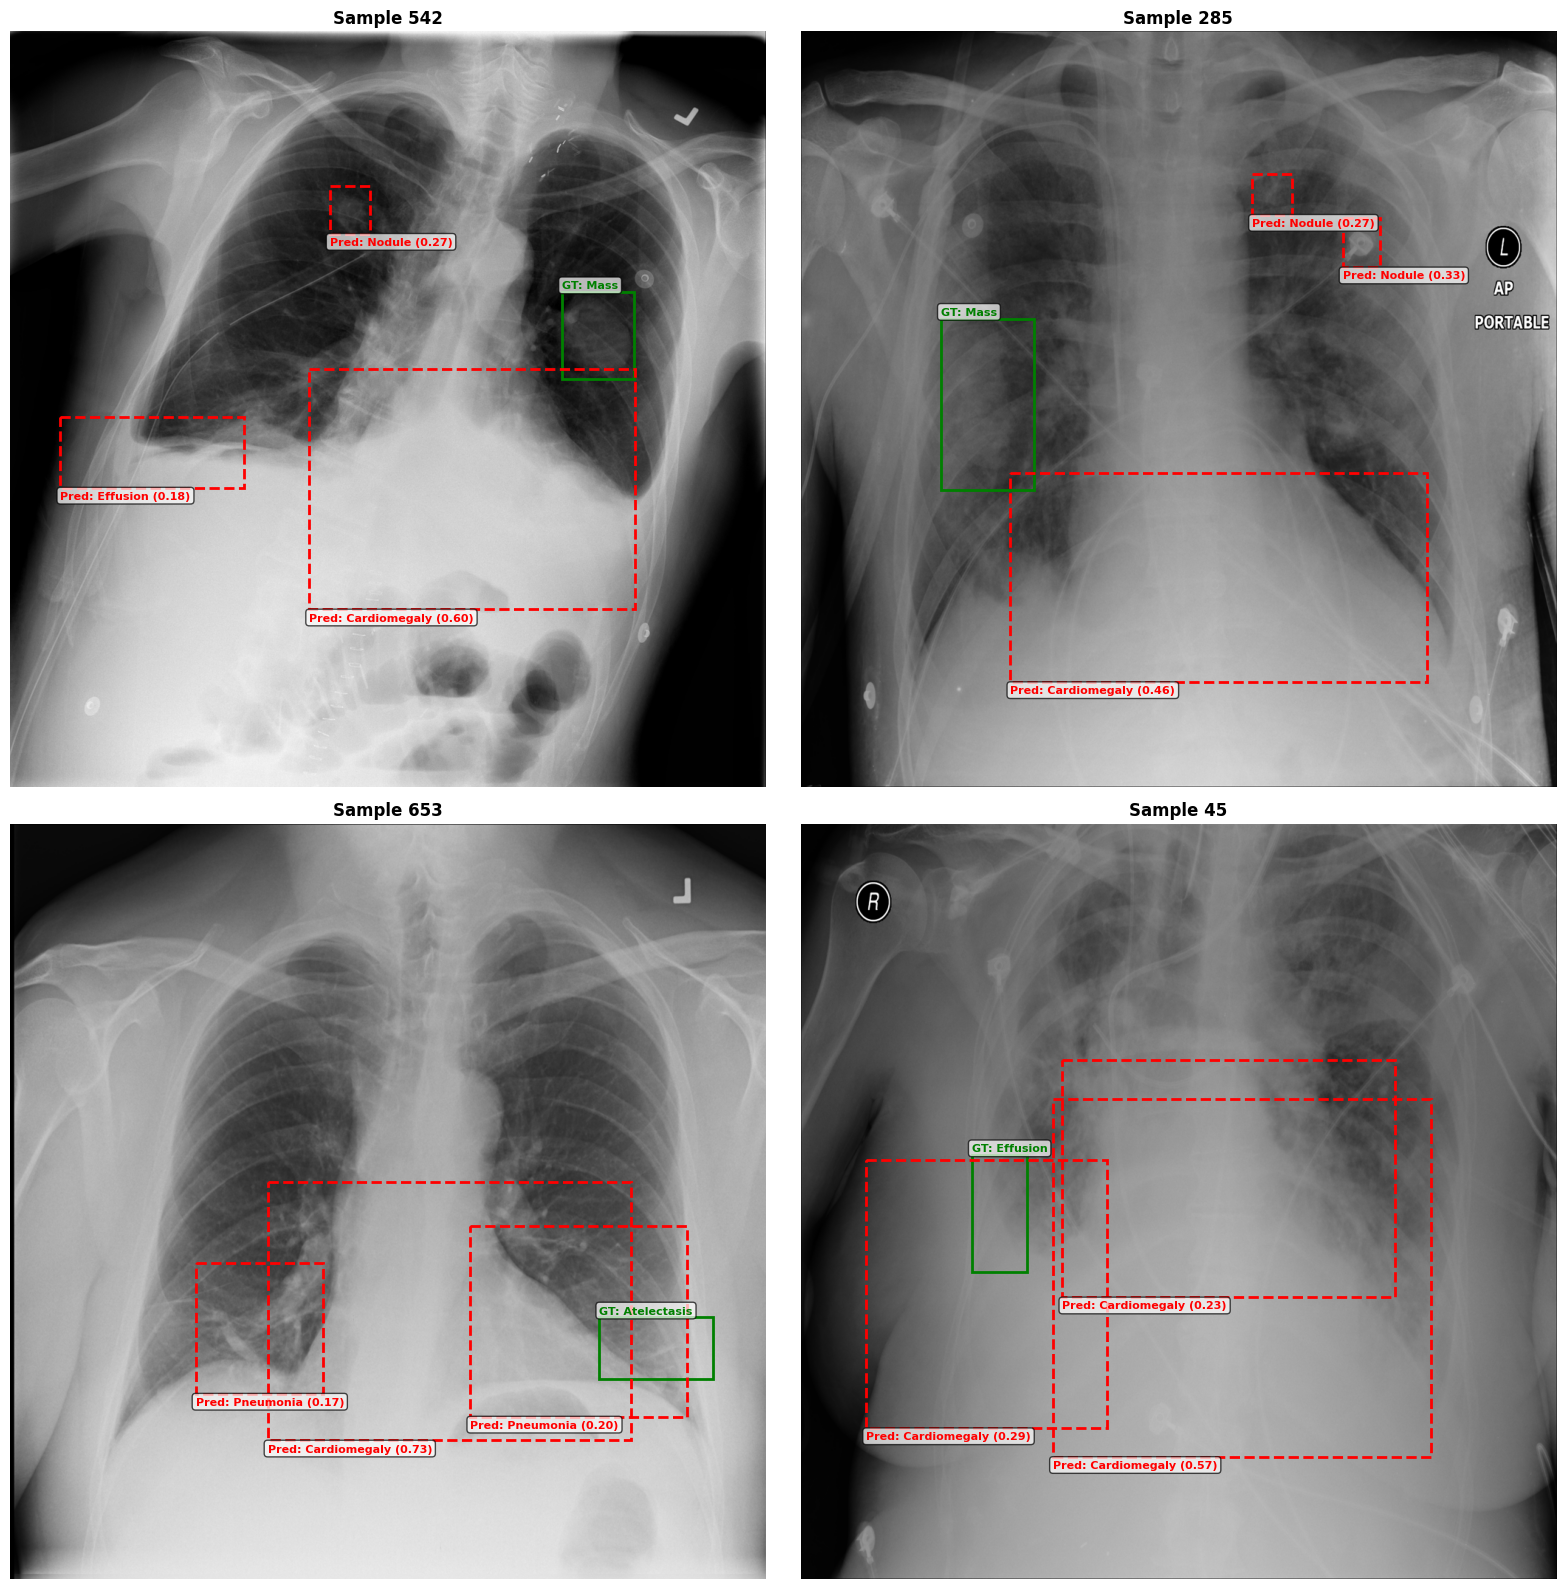

In [12]:
import random

# Visualize multiple predictions
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = axes.flatten()

for i in range(4):
    idx = random.randint(0, len(dataset) - 1)
    image, target = dataset[idx]
    
    model.eval()
    with torch.no_grad():
        prediction = model([image.to(device)])[0]
    
    ax = axes[i]
    ax.imshow(image.permute(1, 2, 0))
    
    # Plot ground truth boxes in green
    gt_boxes = target['boxes']
    for j, box in enumerate(gt_boxes):
        x1, y1, x2, y2 = box.numpy()
        rect = plt.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            fill=False, edgecolor='green', linewidth=2
        )
        ax.add_patch(rect)
        label_id = target['labels'][j].item()
        ax.text(x1, y1-5, f"GT: {id2label[label_id]}", 
                color='green', fontsize=8, weight='bold',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    # Plot predicted boxes in red (top 3 by confidence)
    pred_boxes = prediction['boxes'][:3].cpu()
    pred_scores = prediction['scores'][:3].cpu()
    pred_labels = prediction['labels'][:3].cpu()
    
    for box, score, label_id in zip(pred_boxes, pred_scores, pred_labels):
        x1, y1, x2, y2 = box.numpy()
        rect = plt.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            fill=False, edgecolor='red', linewidth=2, linestyle='--'
        )
        ax.add_patch(rect)
        ax.text(x1, y2+15, f"Pred: {id2label[label_id.item()]} ({score:.2f})", 
                color='red', fontsize=8, weight='bold',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    ax.set_title(f"Sample {idx}", fontsize=12, weight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

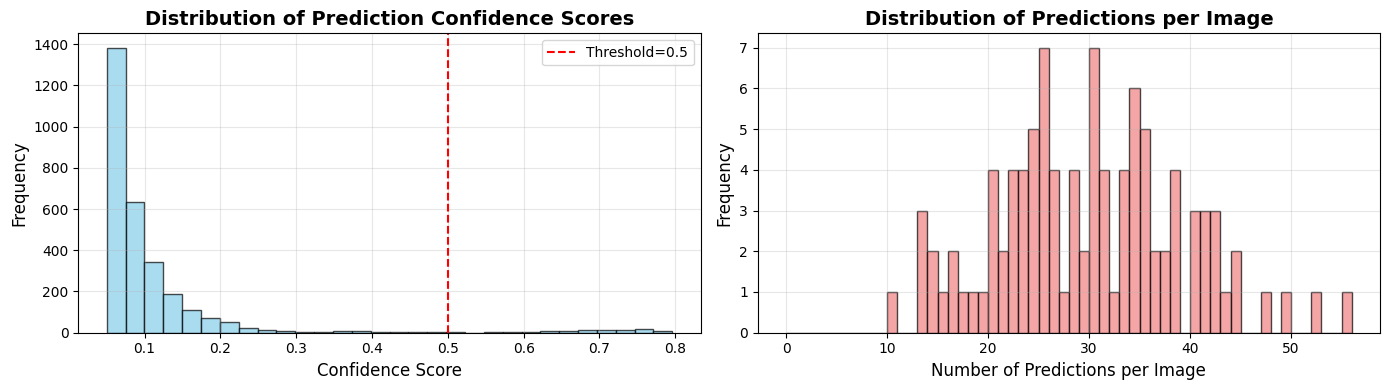

Average confidence score: 0.114
Average predictions per image: 29.54


In [13]:
# Analyze prediction confidence distribution
confidence_scores = []
num_predictions_per_image = []

model.eval()
with torch.no_grad():
    for i in range(min(100, len(dataset))):  # Sample first 100 images
        image, _ = dataset[i]
        prediction = model([image.to(device)])[0]
        
        # Get predictions with confidence > 0.05
        high_conf_preds = prediction['scores'][prediction['scores'] > 0.05]
        confidence_scores.extend(high_conf_preds.cpu().numpy())
        num_predictions_per_image.append(len(high_conf_preds))

# Visualize distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Confidence score distribution
axes[0].hist(confidence_scores, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_xlabel('Confidence Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Prediction Confidence Scores', fontsize=14, weight='bold')
axes[0].axvline(x=0.5, color='r', linestyle='--', label='Threshold=0.5')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Number of predictions per image
axes[1].hist(num_predictions_per_image, bins=range(0, max(num_predictions_per_image)+2), 
             edgecolor='black', alpha=0.7, color='lightcoral')
axes[1].set_xlabel('Number of Predictions per Image', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Predictions per Image', fontsize=14, weight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Average confidence score: {np.mean(confidence_scores):.3f}")
print(f"Average predictions per image: {np.mean(num_predictions_per_image):.2f}")

# 7. Generate Submission

In [14]:
# Load the ID mapping
id_mapping = pd.read_csv(ID_MAP)
print(f"ID Mapping loaded: {len(id_mapping)} entries")
print(f"Columns in mapping: {id_mapping.columns.tolist()}")

# Handle both 'ID' and 'id' column names
id_col = 'ID' if 'ID' in id_mapping.columns else 'id'
img_col = 'image_id' if 'image_id' in id_mapping.columns else 'Image Index'

submission_rows = []

model.eval()
with torch.no_grad():
    test_images = sorted([f for f in os.listdir(TEST_IMG_DIR) 
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    print(f"\nProcessing {len(test_images)} test images...")
    
    for idx, img_name in enumerate(tqdm(test_images)):
        img_path = os.path.join(TEST_IMG_DIR, img_name)
        image = Image.open(img_path).convert('RGB')
        image_tensor = torchvision.transforms.ToTensor()(image).to(device)

        preds = model([image_tensor])[0]

        # Get the unique ID for this image from the mapping
        img_mapping = id_mapping[id_mapping[img_col] == img_name]
        
        if img_mapping.empty:
            print(f"Warning: No ID mapping found for {img_name}, skipping...")
            continue
        
        unique_id = img_mapping[id_col].values[0]

        # Filter boxes by score threshold
        keep_idxs = [i for i, score in enumerate(preds['scores']) if score >= 0.05]
        
        if not keep_idxs:
            # If no predictions, add a dummy row with low confidence
            submission_rows.append({
                'ID': unique_id,
                'image_id': img_name,
                'x_min': 0,
                'y_min': 0,
                'x_max': 1,
                'y_max': 1,
                'confidence': 0.01,
                'label': id2label[0]
            })
            continue

        # Take the highest confidence box
        top_idx = keep_idxs[preds['scores'][keep_idxs].argmax()]
        box = preds['boxes'][top_idx]
        score = preds['scores'][top_idx]
        label = preds['labels'][top_idx]

        submission_rows.append({
            'ID': unique_id,
            'image_id': img_name,
            'x_min': box[0].item(),
            'y_min': box[1].item(),
            'x_max': box[2].item(),
            'y_max': box[3].item(),
            'confidence': score.item(),
            'label': id2label[label.item()]
        })

submission_df = pd.DataFrame(submission_rows)

# Ensure correct column order and names (uppercase 'ID' as per competition requirements)
submission_df = submission_df[['ID', 'image_id', 'x_min', 'y_min', 'x_max', 'y_max', 'confidence', 'label']]

submission_df.to_csv('/kaggle/working/submission.csv', index=False)
print(f"\nSubmission created with {len(submission_df)} predictions")
print(f"Columns: {submission_df.columns.tolist()}")

ID Mapping loaded: 170 entries
Columns in mapping: ['ID', 'image_id']

Processing 170 test images...


100%|██████████| 170/170 [00:20<00:00,  8.37it/s]


Submission created with 170 predictions
Columns: ['ID', 'image_id', 'x_min', 'y_min', 'x_max', 'y_max', 'confidence', 'label']


In [15]:
import os
os.listdir('/kaggle/working')

['submission.csv', '__notebook__.ipynb']

In [16]:
submission_df.head()

,ID,image_id,x_min,y_min,x_max,y_max,confidence,label
0,0,00000150_002.png,365.994751,516.995056,765.885742,796.594116,0.674899,Cardiomegaly
1,1,00000193_019.png,461.988983,516.108826,917.807556,884.572388,0.722988,Cardiomegaly
2,2,00000377_004.png,400.959991,419.917633,902.484192,822.317627,0.723672,Cardiomegaly
3,3,00000398_003.png,406.806854,411.224976,804.127014,801.508240,0.772695,Cardiomegaly
4,4,00000744_006.png,285.242859,406.614258,784.904541,733.884583,0.674418,Cardiomegaly


# 8. Results Summary

In [17]:
print("=" * 60)
print("CHEST X-RAY DETECTION - RESULTS SUMMARY")
print("=" * 60)
print(f"\nDataset Statistics:")
print(f"   - Training images: {train_df['image_id'].nunique()}")
print(f"   - Total annotations: {len(train_df)}")
print(f"   - Number of classes: {num_classes - 1}")
print(f"\nModel Configuration:")
print(f"   - Architecture: Faster R-CNN with ResNet-50 FPN")
print(f"   - Pretrained: Yes (COCO)")
print(f"   - Training epochs: 2")
print(f"   - Learning rate: 1e-4")
print(f"   - Batch size: 4")
print(f"\nEvaluation:")
print(f"   - Metric: Mean Average Precision (mAP@0.5)")
print(f"   - See evaluation cell above for detailed metrics")
print(f"\nSubmission:")
print(f"   - Total predictions: {len(submission_df)}")
print(f"   - File: /kaggle/working/submission.csv")
print(f"   - Format: Includes required ID column")
print("=" * 60)

CHEST X-RAY DETECTION - RESULTS SUMMARY

Dataset Statistics:
   - Training images: 710
   - Total annotations: 814
   - Number of classes: 8

Model Configuration:
   - Architecture: Faster R-CNN with ResNet-50 FPN
   - Pretrained: Yes (COCO)
   - Training epochs: 2
   - Learning rate: 1e-4
   - Batch size: 4

Evaluation:
   - Metric: Mean Average Precision (mAP@0.5)
   - See evaluation cell above for detailed metrics

Submission:
   - Total predictions: 170
   - File: /kaggle/working/submission.csv
   - Format: Includes required ID column
